<a href="https://colab.research.google.com/github/ericfode/diffdugeon/blob/master/diffdungon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import jax
from jax import jit
from jax import grad
import jax.numpy as np
from jax.experimental import optimizers
from jax.experimental import stax
from functools import partial
import numpy as onp
import sys

In [0]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from jax import random

In [0]:
from jax.experimental import optimizers
from jax.tree_util import tree_multimap 

Original Image:


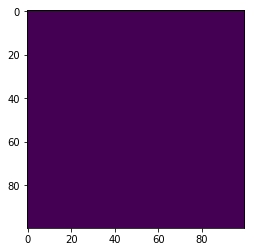

In [0]:
# NHWC layout
key = random.PRNGKey(0)

img = onp.zeros((1, 100, 100), dtype=np.float32)

print("Original Image:")
plt.imshow(img[0]);

In [0]:
start_map = np.zeros((100,100), dtype=np.float32)
start_params= random.uniform(key, (2,100,100), dtype=np.float64,minval=-1.0, maxval=1.0)

opt_init, opt_update, get_params = optimizers.adam(.2)
opt_state = opt_init(start_params)
#plt.imshow(get_params(opt_state))
def apply_mapify(params):
  clipped = np.clip(params,a_min=0, a_max=1)
  return np.round(clipped)

def sigmoid_array(x):                                        
    return 1 / (1 + np.exp(-x))    

def modify(params, start_map):
    return sigmoid_array((start_map + params[1])* params[0] )


def loss(params,start_map,target):
    test = modify(params, start_map)
    return np.abs(target - np.sum(test))



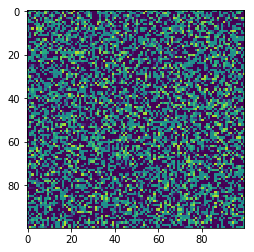

In [0]:

# Define a compiled update step
@jit
def step(i, opt_state, start_map,goal):
    p = get_params(opt_state)
    g = grad(loss)(p, start_map,goal)
    return opt_update(i, g, opt_state)


fig, ax = plt.subplots()
im = plt.imshow(apply_mapify(modify(get_params(opt_state), start_map)))

frames = 111
results = np.zeros((frames,100,100))
for x in range(frames):
  opt_state = step(x, opt_state, start_map,1000)
  vals = modify(get_params(opt_state), start_map)
  results = jax.ops.index_update(results,x,vals)


def one_step(vals,im):
  def inner_step(i):
    new = im.set_data( vals[i])
    return [new]
  return inner_step

anim = FuncAnimation(fig, one_step(results,im) , frames=frames, interval=200)

rc('animation', html='jshtml')
anim